### Imports

In [8]:
import os
import pickle
import numpy as np
import pandas as pd
from glob import glob
from os.path import basename, dirname, isdir, isfile, join
from tqdm import tqdm_notebook as tqdm

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [21]:
root = "/Volumes/hd_4tb/results/training/*/*"
dfs = list()
for folder in tqdm(glob(root)):
    df = pd.read_csv(join(folder, "norm_simple.csv"))
    df["pred"] = np.load(join(folder, "pred.npy"))
    dfs.append(df)
    
df = pd.concat(dfs)

KeyboardInterrupt: 

### Split data

<div hidden>
# root = "/Volumes/hd_4tb/results/training/*/*"
# dfs = list()
# for folder in tqdm(glob(root)):
#     df = pd.read_csv(join(folder, "simple.csv"))
#     df["pred"] = np.load(join(folder, "pred.npy"))
#     dfs.append(df)
    
# df = pd.concat(dfs)
</div>

In [2]:
df = pd.read_feather("/Users/pstetz/Desktop/confidential/.project/summary/norm_all.feather")
df = df.sample(frac=1)
df = df.reset_index(drop=True)
train_x, test_x = train_test_split(df, random_state=5, train_size=0.80)
del df
train_y = train_x.pop("pred")
test_y = test_x.pop("pred")

### Put data into chunks

In [3]:
# N = 1000
# train_x = np.array_split(train_x, N)
# train_y = np.array_split(train_y, N)

### Training

run 1
```
'param_grid': {
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [30, 55, 85],
    'min_split_gain': [0.05, 0.3],
    'min_data_in_leaf': [40, 100]
}

{'learning_rate': 0.1, 'min_data_in_leaf': 100, 'min_split_gain': 0.3, 'num_leaves': 85}
```

run 2
```
params = {
    "learning_rate": [0.1, 0.3],
    "num_leaves": [70, 85, 100],
    "min_split_gain": [0.25, 0.3, 0.35],
    "min_data_in_leaf": [80, 100, 120, 150]
    "n_estimators": [80, 100, 125]
}

0.6304165320899651
{'learning_rate': 0.1, 'min_data_in_leaf': 80, 'min_split_gain': 0.3, 'n_estimators': 125, 'num_leaves': 85}
```

In [4]:
params = {
#     "num_iteration": [3000, 4000, 4500],
#     'max_depth': [5, 7, 15], 
#     'reg_alpha': [0, 0.1], 'reg_lambda': [0.1, 1], 
#     "min_split_gain": [0.25, 0.3, 0.35], "min_data_in_leaf": [80, 100, 120, 150], #'min_child_weight': 4,
#     "n_estimators": [80, 100, 125] #, "feature_fraction": 0.5
}
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    objective="mse",
    learning_rate=0.1,
    min_data_in_leaf=80,
    min_split_gain=0.3,
    n_estimators=125,
    num_leaves=85,
    max_depth=-1,
)
# gs = GridSearchCV(model, param_grid=params, cv=5, verbose=10, scoring=mse_scorer)
model.fit(train_x, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=80,
              min_split_gain=0.3, n_estimators=125, n_jobs=-1, num_leaves=85,
              objective='mse', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

### Cross validate

In [9]:
### Best params
# {'fit_time': array([149.57872677, 132.186064  , 118.14307714, 101.72288799, 96.91477895]),
# 'score_time': array([9.24196792, 8.93173075, 8.33526087, 9.01005602, 7.21525717]),
# 'test_score': array([-0.62940211, -0.6296197 , -0.63166309, -0.62816857, -0.62786861])}

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    objective="mse",
    learning_rate=0.05,
    min_data_in_leaf=80,
    min_split_gain=0.3,
    n_estimators=130,
    num_leaves=90,
    max_depth=-1,
)

cross_validate(model, train_x, train_y, cv=5, scoring=mse_scorer)

{'fit_time': array([116.34972596, 111.00207901, 124.35935616, 151.34821606,
        129.38794994]),
 'score_time': array([8.66684437, 7.27593422, 9.24126291, 9.32100606, 6.76142716]),
 'test_score': array([-0.63277212, -0.63189709, -0.63449741, -0.63090811, -0.63048712])}

### Save model

In [6]:
model_filepath = "/Users/pstetz/Desktop/confidential/.project/run/lgbm/1_lgbm.pkl"

if not isdir(dirname(model_filepath)):
    os.makedirs(dirname(model_filepath))
    
with open(model_filepath, 'wb') as f:
    pickle.dump(model, f)

### Score

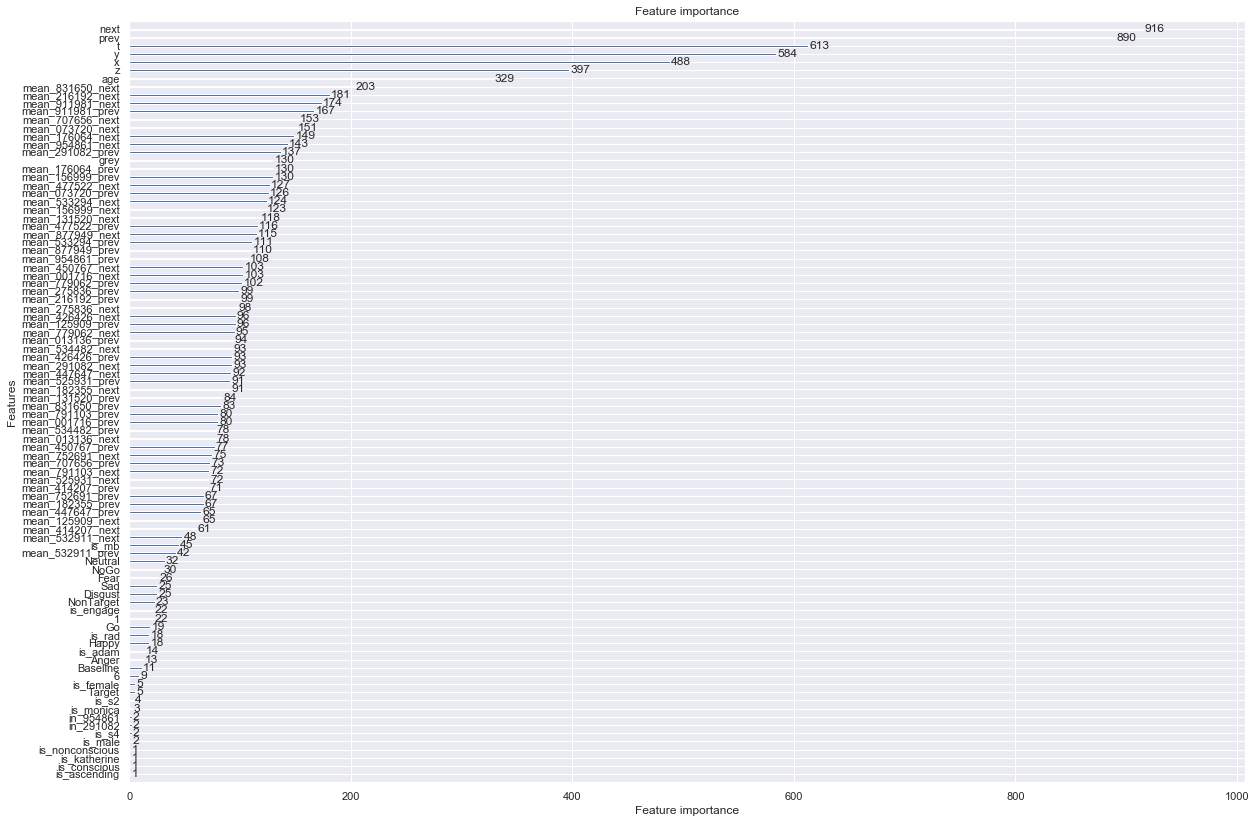

In [9]:
fig, ax = plt.subplots(figsize=(20, 14))
lgb.plot_importance(model, ax=ax);

In [ ]:
expected = model.predict(test_x)
score = mean_squared_error(test_y, expected)

0.6283052798211627


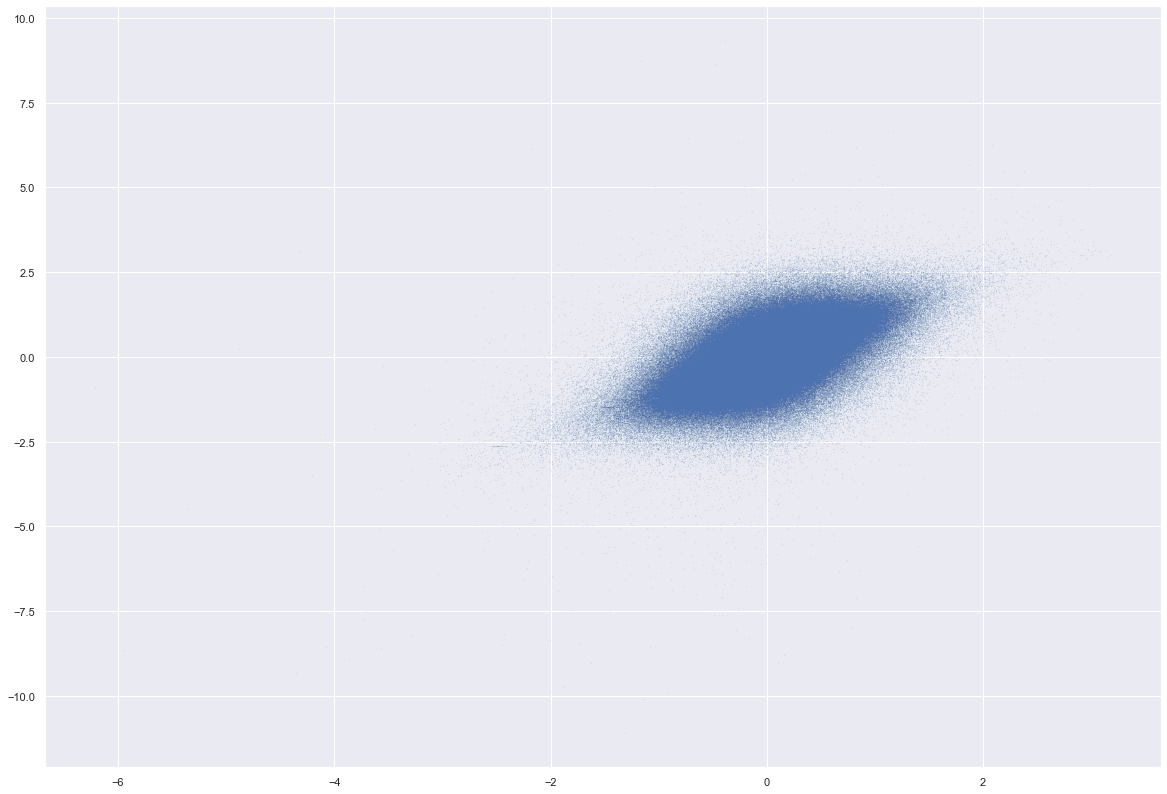

In [20]:
print(score)
fig, ax = plt.subplots(figsize=(20, 14))
ax.plot(expected, test_y, ".", markersize=0.1);